# GRO830 - Démonstration de l'algorithme A*

Vous avez déjà lu la description de l'algorithme A* dans le livre *Introduction to Autonomous Mobile Robot*. Ce document a pour objectif de faire une démonstration de son fonctionnement autant sur un graphe qu'une carte à cellules fixes.

## Version Graphe

Tout d'abord, nous allons mettre en place quelques éléments pour définir notre graphe. Le tableau **nodes** contiendra les identifiants des noeuds (que des entiers pour l'instant) et le tableau **edges** des tuples définissant les liens entre ces noeuds. Les liens sont tous bidirectionnels.

In [229]:
g_nodes = ['MTL', 'BMT', 'SHE', 'DMV', 'QUE'] # Abbréviations pour Montréal, Bromont, Sherbrooke, Drummondville et Québec

g_edges = [('MTL', 'BMT'),
           ('BMT', 'SHE'),
           ('SHE', 'DMV'),
           ('MTL', 'DMV'),
           ('DMV', 'QUE')]

# Les distances et positions sont approximatives :
g_dists = [75, 75, 75, 100, 150]

g_pos = {
    'MTL': (0,0),
    'BMT': (50, 0),
    'SHE': (100, 0),
    'DMV': (100, 50),
    'QUE': (200, 100)
}

Nous pouvons également dessiner ce graphe à l'aide de **networkx** et **matplotlib**. Les positions indiquées ne sont pas respectées à la lettre, mais nous retrouvons tout de même la structure logique du graphe :

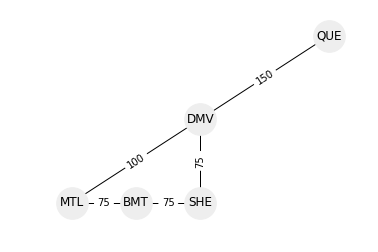

In [230]:
def draw_graph(nodes, edges, dists, pos):
    import networkx as nx
    import matplotlib.pyplot as plt
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    nx.draw_networkx(graph, pos, node_size=1000, node_color="#EEEEEE")
    nx.draw_networkx_edge_labels(graph, pos, dict(zip(edges, dists)))

    # Nécessaire pour agrandir la zone de dessin :
    l,r = plt.xlim()
    t,b = plt.ylim()
    plt.xlim(l-20, r+20)
    plt.ylim(t-10, b+10)
    
    plt.axis('off')
    plt.show()
    
draw_graph(g_nodes, g_edges, g_dists, g_pos)

On peut maintenant mettre en oeuvre l'algorithme. Pour fonctionner, l'algorithme A* a besoin de quelques fonctions : le coût de déplacement entre deux noeuds, les voisins de chaque noeuds et une heuristique permettant d'estimer la distance jusqu'à la cible.

Commençons par le coût entre deux noeuds. Nous avons déjà cette information dans le tableau de distance, mais nous allons l'exprimer par une fonction :

In [231]:
g_costs = dict(zip(g_edges, g_dists)) # Création d'un dictionnaire associant les liens à des distances.
def g_cost(node_a, node_b):
    edge   = (node_a, node_b)
    # Il faut aussi vérifier le lien inverse vu que nous sommes bidirectionnels :
    edge_r = (node_b, node_a)
    
    if (edge in g_costs):
        return g_costs[edge]
    elif (edge_r in g_costs):
        return g_costs[edge_r]
    else:
        # ERROR!
        return -1
    
    #assert edge in g_costs, "g_cost: no edge between %s and %s"%(str(node_a), str(node_b))
    
    
    return g_costs[edge]
        
print("Le coût entre MTL et BMT est %d."%(g_cost('MTL', 'BMT')))

Le coût entre MTL et BMT est 75.


Nous avons également besoin d'une fonction qui retourne la liste des voisins pour un noeud. Nous avons déjà la liste des liens, mais nous devons effectuer une recherche :

In [232]:
def g_neighbors(node):
    assert node in g_nodes, "g_neighbors: node unknown"
    
    neighbors = []
    for (a,b) in g_edges:
        if (a == node):
            neighbors.append(b)
        elif (b == node):
            neighbors.append(a)
    return neighbors
            
print("Les voisins de SHE sont : %s."%(str(g_neighbors("SHE"))))

Les voisins de SHE sont : ['BMT', 'DMV'].


Finalement, nous avons besoin de la fonction heuristique $H$. Nous pourrions utiliser une matrice enregistrant ces distances à voi d'oiseau, mais nous allons utiliser les positions approximatives :

In [233]:
def g_h(node_a, node_b):
    from math import sqrt
    assert node_a in g_pos, "g_h: %s not in g_pos"%(node_a)
    assert node_b in g_pos, "g_h: %s not in g_pos"%(node_b) 
    
    pos_a = g_pos[node_a]
    pos_b = g_pos[node_b]
    
    return sqrt((pos_a[0]-pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)

print("H('MTL', 'QUE') = %d"%(g_h('MTL', 'QUE')))

H('MTL', 'QUE') = 223


Nous avons donc tous les éléments nécessaires pour mettre en place la fonction de l'algorithme. Celle-ci s'occupera de générer le contenu des fonctions $(F,G)$ et retournera le chemin le plus court (s'il existe) :

In [234]:
def astar(start, goal, c_fun, n_fun, h_fun):
    # Cherche le chemin le plus court entre start et goal à l'aide de l'algorithme A*.
    # Retourne un tuple de la séquence et du coût : (seq, cost)
    # Utilise les fonctions :
    #   c_fun(edge): retourne le coût de parcours du lien edge
    #   n_fun(node): retourne les voisins du noeud node
    #   h_fun(node_a, node_b): retourne la valeur de l'heuristique du coût de parcours entre node_a et node_b
    
    from math import inf # Valeur infinie
    
    search_set = [start] # Ensemble de recherche, ne contient que le noeud de départ pour l'instant.
    
    # Dictionnaire contenant le plus bas coût réel du chemin (G) jusqu'au noeud spécifié.
    g = {}
    # On initialise avec g = 0 pour le départ
    g[start] = 0
    
    # Dictionnaire contenant la plus basse valeur de la fonction f(node) pour chaque noeud.
    f = {} 
    # On initialise f(start) avec g (qui est 0) et l'heuristique jusqu'à la fin.
    f[start] = g[start] + h_fun(start, goal)
   
    # Dictionnaire qui conserve pour chaque noeud la provenance permettant la valeur f la plus faible.
    # Utilisé pour reconstruire le chemin lorsque l'objectif est atteint.
    from_node = {}
    # On initialise avec le noeud de départ sans provenance (None).
    from_node[start] = None
    
    while (len(search_set) > 0):
        # On trouve le noeud ayant la plus petite valeur f dans l'ensemble de recherche :
        min_f = inf
        min_n = None
        for n in search_set:
            assert n in f, "Error : %s not in F!"%(str(n))
            if f[n] < min_f:
                min_f = f[n]
                min_n = n
        
        # On retire le noeud ayant le plus petit 'f' et on poursuit avec lui :
        current = min_n
        print("Current: %s, F(%s) = %d"%(current, current, min_f))
        search_set.remove(min_n)
        
        # Si le noeud en cours est l'objectif, c'est qu'aucun autre noeud dans l'espace de recherche n'a
        # un meilleur potentiel du chemin le plus court. On reconstruit le chemin ensuite. 
        if (current == goal):
            path_r = [goal]
            previous = from_node[goal]
            while (previous is not None):
                path_r.append(previous)
                previous = from_node[previous]             
            path_r.reverse() # On remet la liste dans le bon ordre
            return (path_r, g[goal])
        
        ns = n_fun(current) # Les voisins du noeud en cours
        for n in ns:
            # Pour chaque voisin, on calcule sa fonction f et on l'ajoute à l'ensemble de recherche seulement si
            # la valeur de g est plus basse que celle déjà connue pour ce noeud
            g_n = g[current] + c_fun(current, n)
            f_n = g_n + h_fun(n, goal)
            print("G(%s) = %d, F(%s) = %d"%(n, g_n, n, f_n))
            if ((n not in g) or (g_n < g[n])):
                from_node[n] = current
                g[n] = g_n
                f[n] = f_n
                if (n not in search_set):
                    print("Adding %s"%(str(n)))
                    search_set.append(n)
   
    # Nous avons vidé l'espace de recherche sans trouver de solution. Retourner une liste vide et un coût négatif.
    return ([], -1)

Testons maintenant la fonction avec un exemple, Montréal - Sherbrooke :

In [235]:
(seq, cost) = astar('MTL', 'SHE', g_cost, g_neighbors, g_h)
print("Le plus court chemin MTL - SHE est : %s (%d)."%(seq, cost))

Current: MTL, F(MTL) = 100
G(BMT) = 75, F(BMT) = 125
Adding BMT
G(DMV) = 100, F(DMV) = 150
Adding DMV
Current: BMT, F(BMT) = 125
G(MTL) = 150, F(MTL) = 250
G(SHE) = 150, F(SHE) = 150
Adding SHE
Current: DMV, F(DMV) = 150
G(SHE) = 175, F(SHE) = 175
G(MTL) = 200, F(MTL) = 300
G(QUE) = 250, F(QUE) = 391
Adding QUE
Current: SHE, F(SHE) = 150
Le plus court chemin MTL - SHE est : ['MTL', 'BMT', 'SHE'] (150).


On remarque que, malgré le fait que le noeud Sherbrooke a été atteint après avoir visité Bromont, l'algorithme a tout de même testé l'option par Drummondville. En effet, à ce moment-là de la recherche, Drummondville affiche un potentiel égal : F("DMV") = 150.
Il est donc légitime de tester l'option. L'algorithme se rend compte ensuite que ceci se traduirait par un véritable coût de parcours de 175. La branche vers Québec est également ouverte, mais ne sera jamais évaluée puisque $F(QUE) = 391$.

La même situation se produit entre Bromont et Québec, ou l'option de passer par Montréal est évaluée à la toute fin :

In [236]:
(seq, cost) = astar('BMT', 'QUE', g_cost, g_neighbors, g_h)
print("Le plus court chemin BMT - QUE est : %s (%d)."%(seq, cost))

Current: BMT, F(BMT) = 180
G(MTL) = 75, F(MTL) = 298
Adding MTL
G(SHE) = 75, F(SHE) = 216
Adding SHE
Current: SHE, F(SHE) = 216
G(BMT) = 150, F(BMT) = 330
G(DMV) = 150, F(DMV) = 261
Adding DMV
Current: DMV, F(DMV) = 261
G(SHE) = 225, F(SHE) = 366
G(MTL) = 250, F(MTL) = 473
G(QUE) = 300, F(QUE) = 300
Adding QUE
Current: MTL, F(MTL) = 298
G(BMT) = 150, F(BMT) = 330
G(DMV) = 175, F(DMV) = 286
Current: QUE, F(QUE) = 300
Le plus court chemin BMT - QUE est : ['BMT', 'SHE', 'DMV', 'QUE'] (300).


On peut se demander aussi pourquoi le chemin Bromont - Montréal - Drummondville n'est pas évalué. En effet, à la toute fin F(DMV) = 286. Cependant, on sait également que le coût réel de se rendre à Drummondville par Sherbrooke est de 150 plutôt que de 175 en passant par Montréal. Donc même si le potentiel de passer par Drummondville semble plus intéressant à ce moment-ci que la meilleure option trouvée, on sait également que nous avons évalué une option moins coûteuse de passer par Drummondville. C'est pourquoi ce sont les valeurs de G  qui sont évaluées avant d'ajouter un nouveau noeud dans l'ensemble de recherche, et non F.

## Version grille

Maintenant, comment fait-on pour utiliser A* sur une grille régulière ? Commençons par définir une grille où les cases contiennent 1 s'il y a un obstacle et 0 si la voie est libre. Nous allons définir une fonction qui permet de générer aléatoirement ce type de grille de forme carrée :

In [237]:
import numpy as np
def rnd_map(size, n_obs):
    # Génère une matrice de taille size * size contenant n_obs obstacles.
    from random import random
    obs = np.zeros((size,size))
    
    for oi in range(n_obs):
        xl = min(size - 1, int(random()*size))
        xh = min(size - 1, xl + max(1, int(random()*size/3)))
        yl = min(size - 1, int(random()*size))
        yh = min(size - 1, yl + max(1, int(random()*size/3)))
        obs[xl:xh, yl:yh] = 1
            
    return obs

De plus, nous allons définir une façon de déterminer au hasard des cases de départ et d'arrivée :

In [238]:
def rnd_point(shape):
    # Génère un point au hasard dans les limites définies par shape.
    # Retourne un tuple (x,y)
    from random import random
    w = shape[0]
    h = shape[1]
    x = int(random()*w)
    y = int(random()*h)
    return (x,y)

def rnd_task(obs_map):
    # Génère deux points au hasard (start, goal) dans des cases vides de la carte obs_map.
    # Retourne le tuple (start, goal)
    start = rnd_point(obs_map.shape)
    # On répète si on tombe sur autre chose qu'une case vide :
    while (obs_map[start] != 0):
        start = rnd_point(obs_map.shape)
    # Même chose pour l'objectif :
    goal = rnd_point(obs_map.shape)
    while (obs_map[goal] != 0):
        goal = rnd_point(obs_map.shape)
    return (start, goal)

Nous pouvons également afficher cette carte sous forme de "heatmap" avec *Seaborn* et sur laquelle nous ajouterons le départ en bleu et l'objectif en vert :

In [239]:
def draw_map(obs_map, start, goal):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(data=obs_map, annot=False)
    # NOTE : Le système de coordonnées est inversé pour le "scatter plot" :
    (s_y, s_x) = start
    (g_y, g_x) = goal
    plt.scatter(x=s_x+0.4, y=s_y+0.4, color="blue")
    plt.scatter(x=g_x+0.4, y=g_y+0.4, color="green")

On peut maintenant se servir de ces fonctions pour créer une carte de 32x32 avec 8 obstacles au hasard, un départ et une cible valide, et afficher le tout. Comme les valeurs sont générer aléatoirement, n'hésitez-pas à relancer la cellule jusqu'à ce que vous obteniez un résultat intéressant :

On cherche le trajet de (30, 17) à (6, 9).


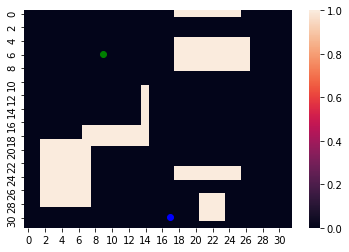

In [240]:
obs_map = rnd_map(32, 8)
(m_start, m_goal) = rnd_task(obs_map)
draw_map(obs_map, m_start, m_goal)
print("On cherche le trajet de %s à %s."%(str(m_start), str(m_goal)))

Maintenant, comment fait-on pour utiliser A* avec ceci ? Devons-nous créer un arbre contenant tous les trajets possibles ? 

Revenons à la définition de la fonction *astar* : celle-ci n'a besoin que de trois fonctions : le coût d'un trajet, la liste des voisins pour un noeud en particulier, et l'heuristique pour estimer le coût à vol d'oiseau. 

Pour le coût d'un trajet, la fonction est particulièrement simple. En effet, on peut considérer que le coût de passer d'une cellule à sa voisine est toujours de 1 :

In [241]:
def m_cost(node_a, node_b):
    # Pour une carte, le coût est toujours de 1.
    # On s'assure tout de même que les cellules sont adjacentes.
    dist_x = abs(node_a[0] - node_b[0])
    dist_y = abs(node_a[1] - node_b[1])
    assert dist_x <= 1 and dist_y <= 1, "m_cost : %s is not a neighbor of %s"%(str(node_a), str(node_b))
    return 1

Ensuite, pour les voisins c'est également facile. Il suffit de générer les tuples avoisinants qui sont vides. 

In [242]:
def m_neighbors_8(node, obs_map):
    # Génère les voisins valides de node selon la carte (obs_map)
    # Connectivité 8.
    # Retourne une liste de tuples dont les cases sont vides (=0).
    ns = []
    x = node[0]
    y = node[1]
    lx = obs_map.shape[0] - 1
    ly = obs_map.shape[1] - 1
    
    min_x = -1 if (x > 0) else 0
    min_y = -1 if (y > 0) else 0
    max_x = 2 if (x < lx) else 1
    max_y = 2 if (y < ly) else 1
    
    for dx in range(min_x, max_x):
        for dy in range(min_y, max_y):
            if ((dx == 0) and (dy == 0)):
                continue
            n = (x+dx, y+dy)
            if (obs_map[n] == 0):
                ns.append(n)
            
    return ns

Finalement, l'heuristique $H$ peut également est évaluée à partir des coordonnées :

In [243]:
def m_h(node_a, node_b):
    from math import sqrt
    (ax, ay) = node_a
    (bx, by) = node_b
    return sqrt((ax-bx)**2 + (ay-by)**2)

On peut maintenant réutiliser *astar* avec ces nouvelles fonctions sans aucune autre modification :

In [244]:
# Permet de définir une nouvelle fonction à un seul paramètre. Ainsi, m_n(node) correspond à m_neighbors_8(node, obs_map)
m_n = lambda node : m_neighbors_8(node, obs_map)

(seq, cost) = astar(m_start, m_goal, m_cost, m_n, m_h)
print("Le plus court chemin entre %s et %s est : %s (%d)"%(m_start, m_goal, seq, cost))

Current: (30, 17), F((30, 17)) = 25
G((29, 16)) = 1, F((29, 16)) = 25
Adding (29, 16)
G((29, 17)) = 1, F((29, 17)) = 25
Adding (29, 17)
G((29, 18)) = 1, F((29, 18)) = 25
Adding (29, 18)
G((30, 16)) = 1, F((30, 16)) = 26
Adding (30, 16)
G((30, 18)) = 1, F((30, 18)) = 26
Adding (30, 18)
G((31, 16)) = 1, F((31, 16)) = 26
Adding (31, 16)
G((31, 17)) = 1, F((31, 17)) = 27
Adding (31, 17)
G((31, 18)) = 1, F((31, 18)) = 27
Adding (31, 18)
Current: (29, 16), F((29, 16)) = 25
G((28, 15)) = 2, F((28, 15)) = 24
Adding (28, 15)
G((28, 16)) = 2, F((28, 16)) = 25
Adding (28, 16)
G((28, 17)) = 2, F((28, 17)) = 25
Adding (28, 17)
G((29, 15)) = 2, F((29, 15)) = 25
Adding (29, 15)
G((29, 17)) = 2, F((29, 17)) = 26
G((30, 15)) = 2, F((30, 15)) = 26
Adding (30, 15)
G((30, 16)) = 2, F((30, 16)) = 27
G((30, 17)) = 2, F((30, 17)) = 27
Current: (28, 15), F((28, 15)) = 24
G((27, 14)) = 3, F((27, 14)) = 24
Adding (27, 14)
G((27, 15)) = 3, F((27, 15)) = 24
Adding (27, 15)
G((27, 16)) = 3, F((27, 16)) = 25
Adding

Comme le résultat en texte est moins intéressant, on peut plutôt le dessiner :

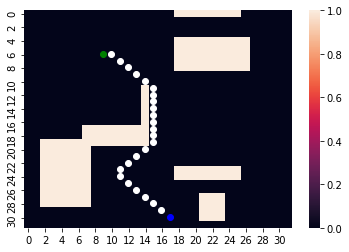

In [245]:
def draw_path(obs_map, start, goal, seq):
    import matplotlib.pyplot as plt
    import numpy as np
    draw_map(obs_map, start, goal)
    points = np.asarray(seq)
    plt.scatter(y=points[:,0]+0.4, x=points[:,1]+0.4, color="white")


draw_path(obs_map, m_start, m_goal, seq[1:len(seq)-1])